# Iteratively block configurations

## Imports

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
from iterated_blocking import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

## Iteratively Block L = 32 configs

In [ ]:
config_dir32 = '../data/configs/32_lattice/separated_data/'
configs32 = sorted([
    config_dir32 + i for i in os.listdir(config_dir32) if i.endswith('.txt')
])
for file in configs32:
    block_configs(file)

In [20]:
config_dir32_b16 = '../data/iterated_blocking/32_lattice/blocked_16/'
configs32_b16 = sorted([
    config_dir32_b16 + i for i in os.listdir(config_dir32_b16) if
    i.endswith('.txt')
])
for file in configs32_b16:
    block_configs(file)

['../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.0.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.1.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.2.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.3.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.4.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.5.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.6.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.7.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.8.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.85.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.9.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.95.txt',
 '../data/iterated_blocking/32_lattice/blocked_16/

In [22]:
config_dir16_b8 = '../data/iterated_blocking/16_lattice/blocked_8/'
configs16_b8 = sorted([
    config_dir16_b8 + i for i in os.listdir(config_dir16_b8) if
    i.endswith('.txt')
])
for file in configs16_b8:
    block_configs(file)

['../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.0.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.1.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.2.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.3.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.4.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.5.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.6.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.7.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.8.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.85.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.9.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.95.txt',
 '../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_2.0.txt

In [25]:
config_dir8_b4 = '../data/iterated_blocking/8_lattice/blocked_4/'
configs8_b4 = sorted([
    config_dir8_b4 + i for i in os.listdir(config_dir8_b4) if
    i.endswith('.txt')
])
for file in configs8_b4:
    block_configs(file)

['../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.0.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.1.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.2.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.3.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.4.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.5.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.6.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.7.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.8.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.85.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.9.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.95.txt',
 '../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_2.0.txt',
 '../data/

In [27]:
config_dir4_b2 = '../data/iterated_blocking/4_lattice/blocked_2/'
configs4_b2 = sorted([
    config_dir4_b2 + i for i in os.listdir(config_dir4_b2) if
    i.endswith('.txt')
])
for file in configs4_b2:
    block_configs(file)

['../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.0.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.1.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.2.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.3.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.4.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.5.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.6.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.7.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.8.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.85.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.9.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.95.txt',
 '../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_2.0.txt',
 '../data/

## Run CountBonds on blocked configs

In [49]:
count_bonds32 = CountBonds(32, verbose=True, num_blocks=5, 
                           data_dir=config_dir32)
Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds32.bond_stats.keys())
])
# 14m 9s, num_blocks=2

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.85.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.95.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_

In [50]:
count_bonds16 = CountBonds(16, verbose=True, num_blocks=5, 
                           data_dir=config_dir32_b16)
Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds16.bond_stats.keys())
])
# 3m 26s, num_blocks=2

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.0.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.1.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.2.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.3.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.4.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.5.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.6.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.7.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.8.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.85.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_b

In [51]:
count_bonds8 = CountBonds(8, verbose=True, num_blocks=5,
                           data_dir=config_dir16_b8)
Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds8.bond_stats.keys())
])
# 58.9s, num_blocks=2

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.0.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.1.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.2.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.3.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.4.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.5.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.6.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.7.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.8.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.85.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.9.txt

In [52]:
count_bonds4 = CountBonds(4, verbose=True, num_blocks=5,
                           data_dir=config_dir8_b4)
Nb4 = np.array([
    (i[0], i[1]) for i in list(count_bonds4.bond_stats.values())
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in list(count_bonds4.bond_stats.values())
])
Nb4_temps = np.array([
    float(i) for i in list(count_bonds4.bond_stats.keys())
])
# 21.4s, num_blocks=2

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.0.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.1.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.2.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.3.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.4.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.5.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.6.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.7.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.8.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.85.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.9.txt

Reading i

## Plot  $\langle \Delta_{N_b}^2\rangle$ vs. $T$

<IPython.core.display.Javascript object>


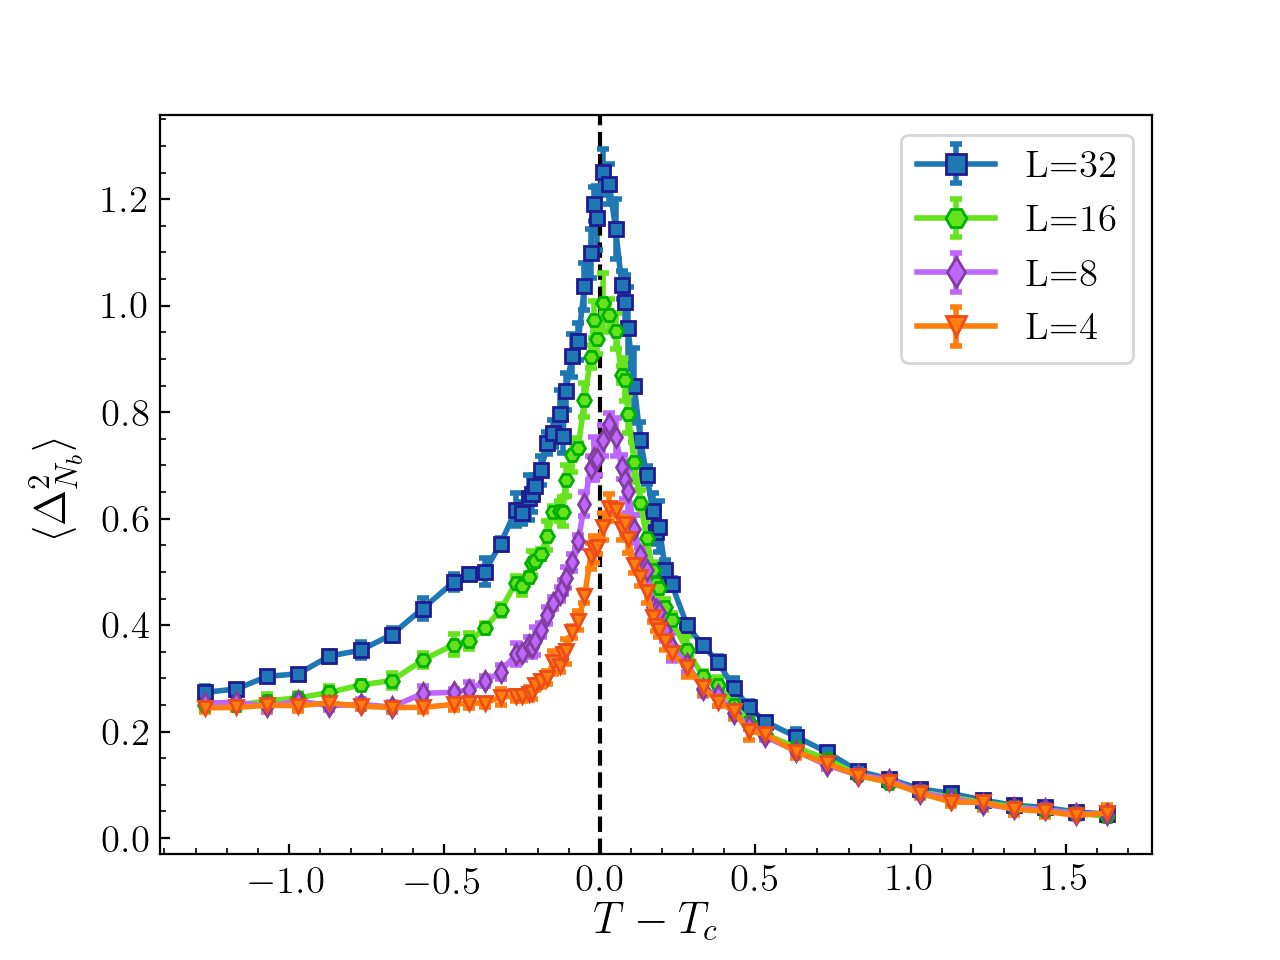

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'$T-T_c$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$')

Saving file to: ../plots/iterated_blocking/bond_stats/delta_Nb_all_9.png


In [53]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32_temps-Tc), delta_Nb32[:,0]/(2*32*32), 
            yerr=delta_Nb32[:,1]/(32*32),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16_temps-Tc), delta_Nb16[:,0]/(2*16*16), 
            yerr=delta_Nb16[:,1]/(16*16),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8_temps-Tc), delta_Nb8[:,0]/(2*8*8),
            yerr=delta_Nb8[:,1]/(8*8),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4_temps-Tc), delta_Nb4[:,0]/(2*4*4), 
            yerr=delta_Nb4[:,1]/(4*4),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$T-T_c$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


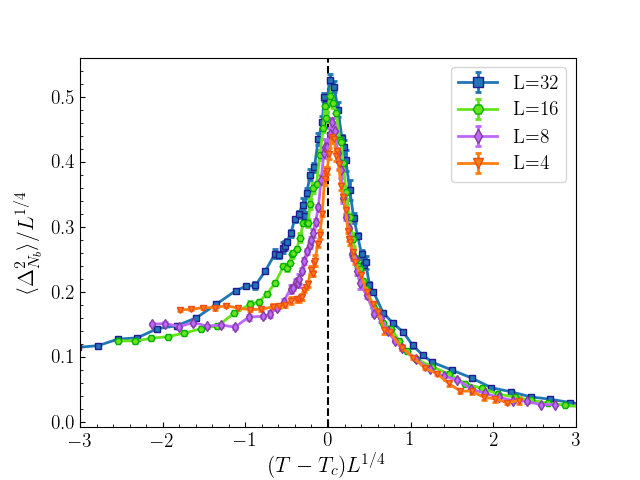

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(-3.0, 3.0)

Text(0.5,0,'$(T-T_c)L^{1/4}$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/L^{1/4}$')

Saving file to: ../plots/iterated_blocking/bond_stats/collapsed/delta_Nb_all_collapsed_6.png


In [59]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32_temps-Tc)*32**(1./4), delta_Nb32[:,0]/(2*32*32*32**(1./4)), 
            yerr=delta_Nb32[:,1]/(2*32*32*32**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16_temps-Tc)*16**(1./4), delta_Nb16[:,0]/(2*16*16*16**(1./4)), 
            yerr=delta_Nb16[:,1]/(2*16*16*16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8_temps-Tc)*8**(1./4), delta_Nb8[:,0]/(2*8*8*8**(1./4)),
            yerr=delta_Nb8[:,1]/(2*8*8*8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4_temps-Tc)*4**(1./4), delta_Nb4[:,0]/(2*4*4*4**(1./4)), 
            yerr=delta_Nb4[:,1]/(2*4*4*4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-3., 3.)
ax.set_xlabel('$(T-T_c)L^{1/4}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle/L^{1/4}$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/collapsed/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_collapsed_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()